In [1]:
import xarray as xr
import gcsfs
from glob import glob
from tqdm import tqdm
from dask.diagnostics import ProgressBar, Profiler
import dask
import os
import shutil
import numpy as np
from dask.distributed import Client, LocalCluster
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.display import clear_output


In [47]:
plt.rcParams.update({'font.size': 14
    , 'legend.markerscale': 1., 'axes.titlesize': 14, 'axes.labelsize' : 12,
      'legend.fontsize' : 13,'legend.handlelength': 3})

plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10)

color2 = '#6495ed'
color1 = '#ff6347'
color5 = '#8470ff'
color3 = '#3cb371'
color4 = '#ffd700'
color6 = '#ba55d3'
plt.rcParams['figure.figsize'] = (14.,5.)

In [2]:
ddir = '/swot/SUM03/tmp/CESM/'

In [4]:
client = Client('tcp://129.236.21.48:8089')
client

Client Scheduler: tcp://129.236.21.48:8089 Dashboard: http://129.236.21.48:8787/status,Cluster Workers: 16 Cores: 16 Memory: 8.66 TB


In [5]:
ds=xr.open_zarr(ddir+'hybrid_v5_rel04_BC5_ne120_t12_pop62', auto_chunk=False).chunk({'time': 1})
ds

/home/as4479/new_miniconda/miniconda/envs/pangeo/lib/python3.6/site-packages/xarray/coding/times.py:132: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  enable_cftimeindex)
/home/as4479/new_miniconda/miniconda/envs/pangeo/lib/python3.6/site-packages/xarray/coding/variables.py:69: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  return self.func(self.array)


<xarray.Dataset>
Dimensions:             (nlat: 2400, nlon: 3600, time: 14965, z_t: 62, z_t_150m: 15, z_w: 62, z_w_bot: 62, z_w_top: 62)
Coordinates:
    ANGLE               (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    ANGLET              (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    DXT                 (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    DXU                 (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    DYT                 (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    DYU                 (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    HT                  (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    HTE                 (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    HTN                 (nlat, nlon) float64 dask.

In [6]:
from xbatcher import BatchGenerator

In [7]:
ds=ds.rename({'U1_1':'U', 'V1_1':'V', 'TAUX_2':'TAUX', 'TAUY_2':'TAUY', 'SSH_2':'SSH', 'ULONG':'XU', 'ULAT':'YU'})

In [89]:
def threeD_coords(lon,lat):
    X = np.sin(np.radians(lat))
    Y = np.sin(np.radians(lon))*np.cos(np.radians(lat))
    Z = -np.cos(np.radians(lon))*np.cos(np.radians(lat))
    return (X,Y,Z)

def extract_needed_variables(batch):
    shift_vars = ['SSH','XU','YU','TAUX','TAUY','SST']
    coord_vars = ['XU','YU']

    shifts = {'_e': dict(nlon_input=-1),
              '_w': dict(nlon_input=1),
             '_n': dict(nlat_input=-1),
             '_s': dict(nlat_input=1),
             '_ne': dict(nlon_input=-1,nlat_input=-1),
             '_nw': dict(nlon_input=1,nlat_input=-1),
             '_se': dict(nlon_input=-1,nlat_input=1),
             '_sw': dict(nlon_input=1,nlat_input=1),}

    for var in shift_vars:
        for suf, shift in shifts.items():
            batch[var + suf] = batch[var].shift(**shift)
            
    suffixes = ['','_e','_w','_n','_s','_ne','_nw','_se','_sw']
    for suf in suffixes:
        batch['X'+suf],batch['Y'+suf],batch['Z'+suf], = threeD_coords(batch['XU'+suf],batch['YU'+suf])
    for var in coord_vars:
        for suf in suffixes:
            batch = batch.drop([var+suf])
    return batch

targets=['U','V']
features = ['X', 'Y', 'Z','SSH','SST','TAUX','TAUY']
sufx = ['','_e','_w','_n','_s','_ne','_nw','_se','_sw']
feature_cols = [feat+suf for feat in features for suf in sufx]


from sklearn.model_selection import train_test_split

def ds_to_df(batch, w_validation=False, choice='training'):
    #df = batch.reset_index('sample').to_dataframe()
    #X = df.dropna().reset_index(drop=True).loc[:, feature_cols]
    #y = df.dropna().reset_index(drop=True).loc[:, targets]
    df = batch.drop('sample').to_dataframe().dropna().reset_index(drop=True)
    X = df.loc[:, feature_cols]
    y = df.loc[:, targets]
    
    if w_validation:
        X,X_t,y,y_t = train_test_split(X,y,test_size=0.2)
        if (choice=='training'):
            return (X,y)
        elif (choice=='validation'):
            return (X_t,y_t)
    else:
        return (X,y)
    

In [42]:
def actual_generator(batchsize ='1d', **kwargs):
    vars_wanted = ['SST','SSH', 'TAUX','TAUY','XU', 'YU','U','V']
    if (batchsize=='1d'):
        smallbatchsize=100
        bg = BatchGenerator(ds.reset_coords()[vars_wanted],
                    input_dims={'nlon': 100, 'nlat': 100}, batch_dims={'time': 1},
                    input_overlap={'nlon' : 1, 'nlat' : 1},
                    concat_input_dims=True)
        for batch in bg:
            yield  ds_to_df(extract_needed_variables(batch), kwargs)
    elif (batchsize==1200):
        bg = BatchGenerator(ds.reset_coords()[vars_wanted],
                input_dims={'nlon': batchsize, 'nlat': batchsize}, batch_dims={'time': 1},
                concat_input_dims=True)
        for batch in bg:
            for jt in range(len(batch.sample)):
                bt = batch.isel(sample=jt)
                yield  ds_to_df(extract_needed_variables(bt), kwargs)
    elif(batchsize==600):
        bg = BatchGenerator(ds.reset_coords()[vars_wanted],
                input_dims={'nlon': batchsize, 'nlat': batchsize}, batch_dims={'time': 1},
                concat_input_dims=True)
        for batch in bg:
            for jt in range(len(batch.sample)):
                bt = batch.isel(sample=jt)
                yield  ds_to_df(extract_needed_variables(bt), kwargs)
    else:
        raise ValueError('unrecognized batchsize')


In [43]:
import tensorflow as tf
from tensorflow import keras

/home/as4479/new_miniconda/miniconda/envs/pangeo/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [97]:
len(feature_cols)

63

In [98]:
# Define basic architecture
model = keras.Sequential([
    keras.layers.Dense(80, activation=tf.nn.relu,
                       input_shape=(len(feature_cols),),
                       name='hidden_layer_1',),
    keras.layers.Dense(80, activation=tf.nn.relu, 
                       name='hidden_layer_2'),
    keras.layers.Dense(80, activation=tf.nn.relu, 
                       name='hidden_layer_3'),
    keras.layers.Dense(80, activation=tf.nn.relu, 
                       name='hidden_layer_4'),
    keras.layers.Dense(20, activation=tf.nn.relu, 
                       name='hidden_layer_5'),
    keras.layers.Dense(2, name='output_layer',)
])

# Define your optimizer asdf
#optimizer = tf.train.AdamOptimizer()
model.compile(loss='mse',
            optimizer='adam',
            metrics=['mae', 'mse','accuracy'])

# show a summary of the data
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer_1 (Dense)       (None, 80)                5120      
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 80)                6480      
_________________________________________________________________
hidden_layer_3 (Dense)       (None, 80)                6480      
_________________________________________________________________
hidden_layer_4 (Dense)       (None, 80)                6480      
_________________________________________________________________
hidden_layer_5 (Dense)       (None, 20)                1620      
_________________________________________________________________
output_layer (Dense)         (None, 2)                 42        
Total params: 26,222
Trainable params: 26,222
Non-trainable params: 0
_________________________________________________________________


In [99]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

# updatable plot
# a minimal example (sort of)

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.mae = []
        self.val_mae = []
        self.accuracy = []
        self.val_accuracy = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.mae.append(logs.get('mean_absolute_error'))
        self.val_mae.append(logs.get('val_mean_absolute_error'))
        self.accuracy.append(logs.get('acc'))
        self.val_accuracy.append(logs.get('val_acc'))
        
        self.i += 1
        
        clear_output(wait=True)
        plt.figure(figsize=(18,5))
        plt.subplot(131)
        plt.plot(self.x, self.losses,alpha=0.5,color=color2,label="loss")
        plt.plot(self.x, self.val_losses,alpha=0.5,color=color1, label="val loss")
        plt.legend()
        plt.xlabel(r'Epoch [$=1$ day if $batchsize<1$ day]');
        plt.ylabel('Mean Square Error');
        
        plt.subplot(132)
        plt.plot(self.x, self.mae,alpha=0.5,color=color2, label="training")
        plt.plot(self.x, self.val_mae,alpha=0.5,color=color1, label="validation")
        plt.legend()
        plt.xlabel('Epoch');
        plt.ylabel(r'Mean Abs Error [$cm/s$]');
        
        plt.subplot(133)
        plt.plot(self.x, self.accuracy,color=color2,alpha=0.5, label="training")
        plt.plot(self.x, self.val_accuracy,alpha=0.5,color=color1, label="validation")
        plt.legend()
        plt.xlabel('Epoch');
        plt.ylabel('Model Accuracy');
        plt.show();
        
plot_losses = PlotLosses()

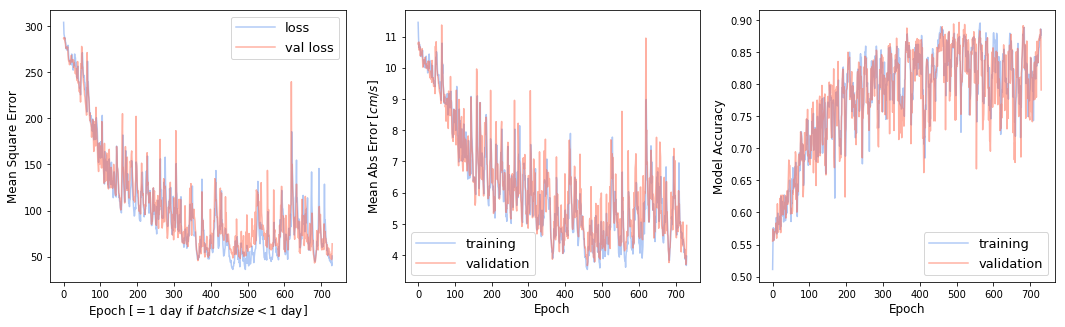

6/6 [==============================] - 74s 12s/step - loss: 55.3461 - mean_absolute_error: 4.1477 - mean_squared_error: 55.3458 - acc: 0.8768 - val_loss: 64.0192 - val_mean_absolute_error: 4.9493 - val_mean_squared_error: 64.0190 - val_acc: 0.7910
Epoch 732/750


In [ ]:
model_hist = model.fit_generator(generator=actual_generator(batchsize=1200,w_validation=True, choice='training'),
                                 validation_data=actual_generator(batchsize=1200,w_validation=True, choice='validation'),
                                 steps_per_epoch=6, validation_steps=6, epochs=750, callbacks=[plot_losses])
#, use_multiprocessing=True, workers=10)
